In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("/home/ensai/imatag/website_categorization_custom/categorization/Datasets/Feature_dataset_2023-02-09_ORIGINAL.csv")


In [4]:
df.head()

,url,main_category,main_category_confidence,tld,tokens
0,http://000webhost.com,Internet_and_Telecom,0.5581,com,"['web', 'hosting', 'host', 'website', 'cpanel'..."
1,http://022menchuang.net,Career_and_Education,1.0000,net,['']
2,http://0calc.com,Science,0.5606,com,"['web', 'scientific', 'calculator', 'register'..."
3,http://1-x-bet.com,Gambling,0.7741,com,['']
4,http://10086.cn,Internet_and_Telecom,0.5590,cn,[]


In [5]:
df.main_category.value_counts()

Food_and_Drink              1242
Health                      1224
Beauty_and_Fitness          1062
Law_and_Government          1058
Books_and_Literature        1003
Reference                    966
Sports                       863
Autos_and_Vehicles           854
Gambling                     741
People_and_Society           675
Finance                      634
Internet_and_Telecom         571
Computer_and_Electronics     570
Science                      533
Business_and_Industry        532
News_and_Media               455
Career_and_Education         453
Travel                       396
Games                        354
Shopping                     347
Arts_and_Entertainment       335
Recreation_and_Hobbies       239
Pets_and_Animals             221
Adult                        119
Home_and_Garden               89
Name: main_category, dtype: int64

In [6]:
import ast

def convert_to_list(row):
    return ast.literal_eval(row['tokens'])

In [7]:
df['tokens'] = df.apply(convert_to_list, axis = 1)

In [8]:
df = df[df['tokens'].map(len) > 1]

In [9]:
df.head()

,url,main_category,main_category_confidence,tld,tokens
0,http://000webhost.com,Internet_and_Telecom,0.5581,com,"[web, hosting, host, website, cpanel, php, sal..."
2,http://0calc.com,Science,0.5606,com,"[web, scientific, calculator, register, login,..."
5,http://100diet.net,Health,0.5991,net,"[diet, diet, javascript, diet]"
7,http://1091.co.jp,Sports,0.5912,jp,"[co, iupdate, tweet, www, co, qr, qr, url, cop..."
8,http://10bet.com,Gambling,0.7795,com,"[bet, bet, sport, betting, welcome, bonus, ope..."


In [10]:
X = pd.DataFrame(df, columns=['tokens'])
Y = pd.DataFrame(df, columns=['main_category'])

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [13]:
import nltk

In [14]:
words_frequency = {}
for category in y_train.main_category.unique():
    print(category)
    all_words = []
    df_temp = X_train[y_train.main_category == category]
    for word in df_temp.tokens:
        all_words.extend(word)
    most_common = [word[0] for word in nltk.FreqDist(all_words).most_common(20000)]
    words_frequency[category] = most_common

Health
Business_and_Industry
Adult
Books_and_Literature
Shopping
People_and_Society
Food_and_Drink
Pets_and_Animals
Finance
Gambling
Science
Beauty_and_Fitness
Reference
Sports
News_and_Media
Career_and_Education
Arts_and_Entertainment
Law_and_Government
Autos_and_Vehicles
Games
Computer_and_Electronics
Recreation_and_Hobbies
Internet_and_Telecom
Travel
Home_and_Garden


In [15]:
def predict_category(tokens,words_frequency = words_frequency):
    category_weights = []
    for category in words_frequency:
        weight = 0
        intersect_words = set(words_frequency[category]).intersection(set(tokens))
        for word in intersect_words:
            if word in tokens:
                index = words_frequency[category].index(word)
                weight += 20000 - index
        category_weights.append(weight)

    category_index = category_weights.index(max(category_weights))
    main_category = list(words_frequency.keys())[category_index]
    category_weight = max(category_weights)
    category_weights[category_index] = 0
    category_index = category_weights.index(max(category_weights))
    main_category_2 = list(words_frequency.keys())[category_index]
    category_weight_2 = max(category_weights)
    return main_category


In [38]:
y_pred = []

In [17]:
import concurrent.futures

In [18]:
X_test

,tokens
9218,"[law, firm, success, withersworldwide, newsroo..."
11024,"[neverthirsty, bible, study, bible, spiritual,..."
10427,"[buy, chocolate, gift, hamper, australia, choc..."
502,"[accueil, hotel, paris, collection, tels, tels..."
5043,"[fusce, sem, sapien, tristique, ligula, justo,..."
...,...
14581,"[bain, capital, investor, login, location, bai..."
2276,"[landr, creative, tool, musiciansthis, app, wo..."
681,"[buccaneer, tampa, bay, buccaneer, skip, main,..."
11000,"[english, french, urdu, pashto, swahili, hausa..."


In [19]:
with concurrent.futures.ThreadPoolExecutor(32) as executor:
    futures = []
    for index,row in X_test.iterrows():
        futures.append(executor.submit(predict_category, tokens=row['tokens']))

In [34]:
len(X_test)

2985

In [39]:
for future in futures:
    y_pred.append(future.result())

In [40]:
len(y_pred)

2985

In [41]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

In [42]:
accuracy

0.5333333333333333

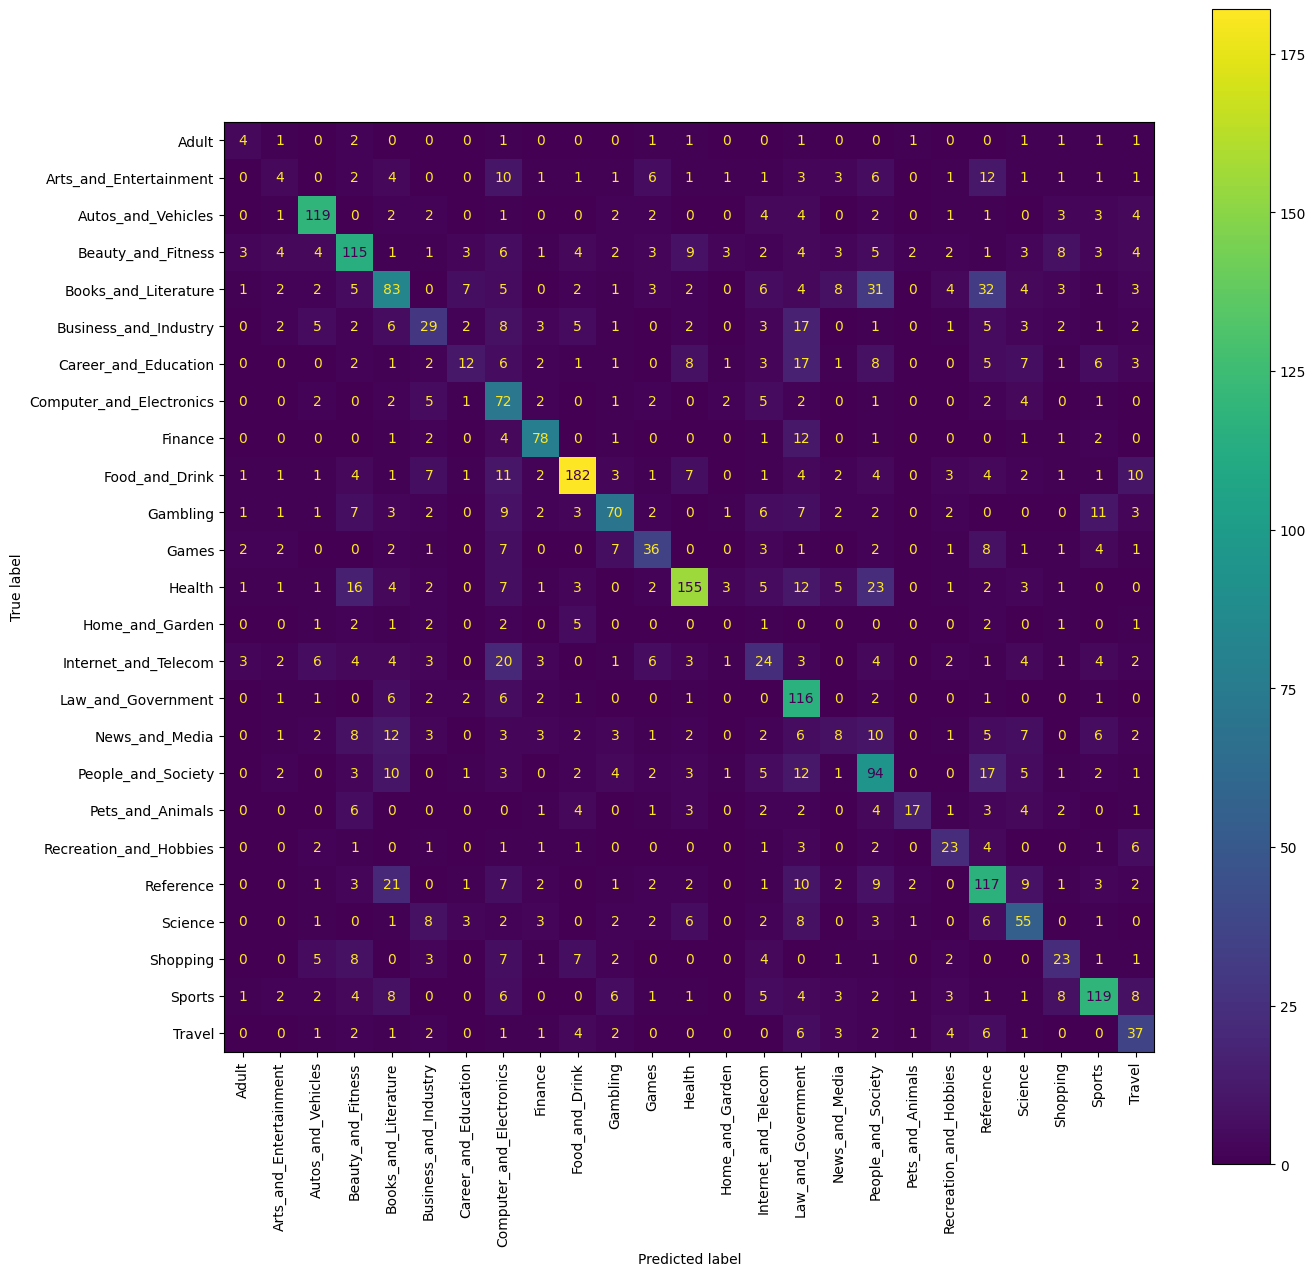

In [43]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred,xticks_rotation='vertical')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 

In [44]:
data_tokens = [' '.join(row['tokens']) for index,row in X.iterrows()]


In [45]:
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=20000)
X_custom = matrix.fit_transform(data_tokens).toarray()

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_custom, Y, random_state=42)

In [10]:
#y = [data[i]['class'] for i in range(len(data))]

In [156]:
count = pd.Series(y).value_counts()

In [157]:
count

Food_and_Drink              1242
Health                      1224
Beauty_and_Fitness          1062
Law_and_Government          1058
Books_and_Literature        1003
Reference                    966
Sports                       863
Autos_and_Vehicles           854
Gambling                     741
People_and_Society           675
Finance                      634
Internet_and_Telecom         571
Computer_and_Electronics     570
Science                      533
Business_and_Industry        532
News_and_Media               455
Career_and_Education         453
Travel                       396
Games                        354
Shopping                     347
Arts_and_Entertainment       335
Recreation_and_Hobbies       239
Pets_and_Animals             221
Adult                        119
Home_and_Garden               89
dtype: int64

In [59]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import balanced_accuracy_score
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

#Predict Class
y_pred_custom = classifier.predict(X_test)

#Accuracy 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_custom)

/home/ensai/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [60]:
accuracy

0.5802345058626466

In [56]:
len(X_test)

2985

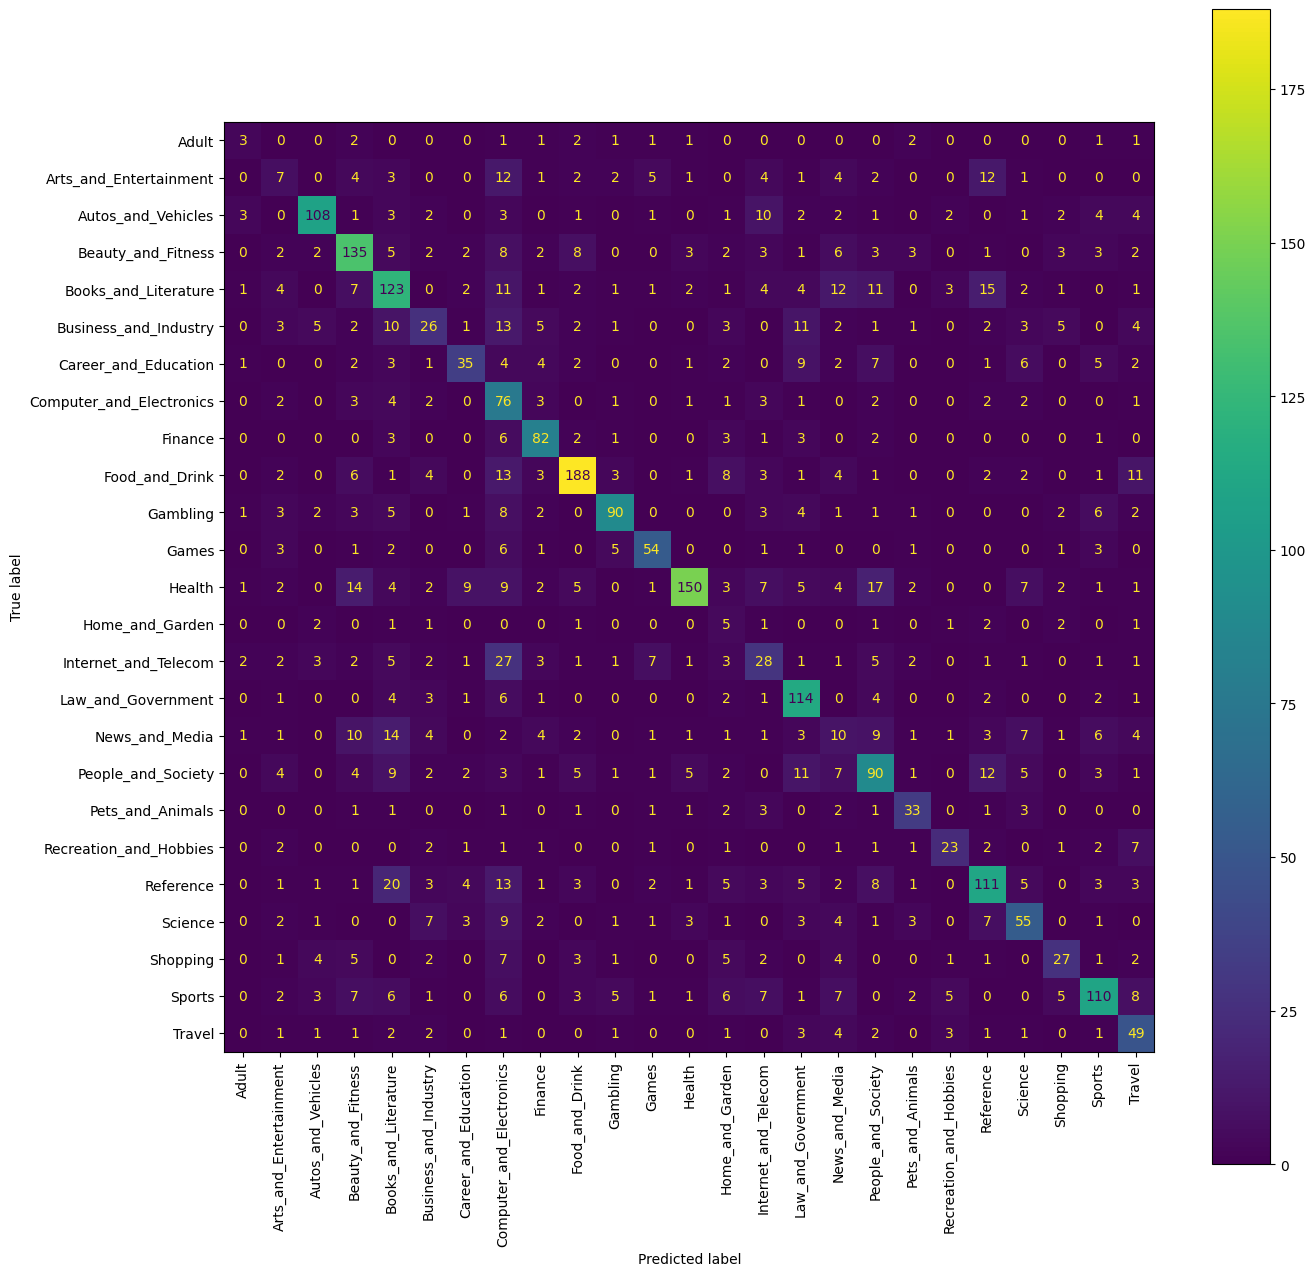

In [61]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, y_pred_custom)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom,xticks_rotation='vertical')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 

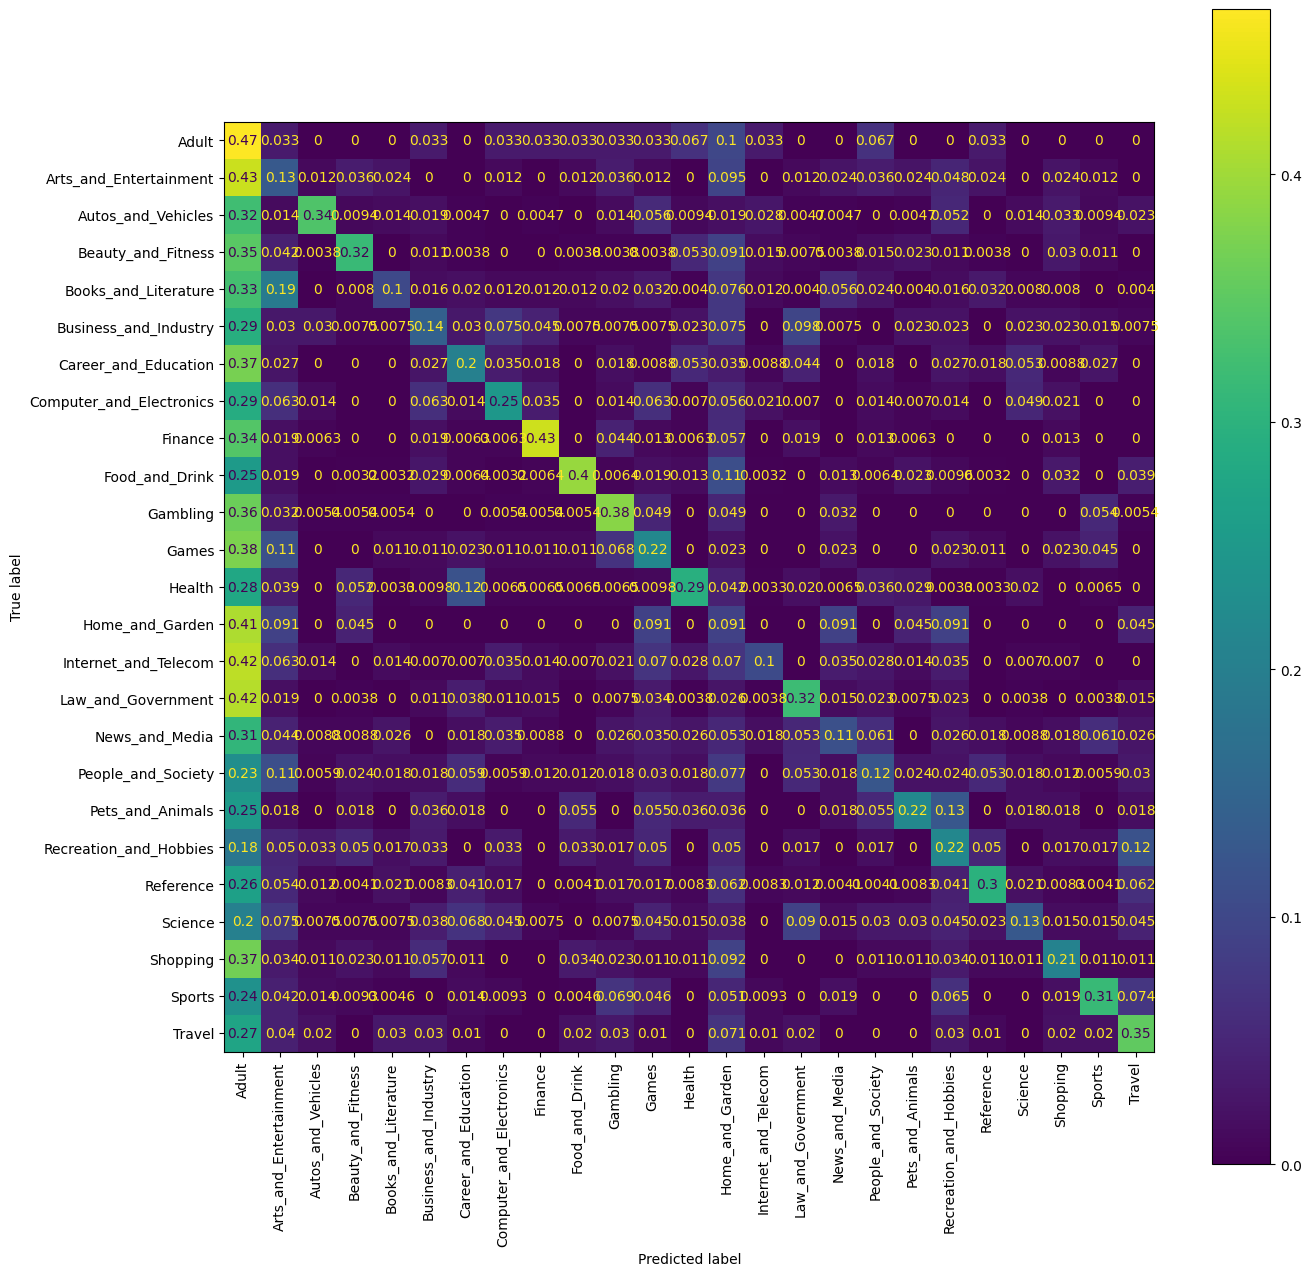

In [25]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred,xticks_rotation='vertical', normalize='true')

fig = cm_display.ax_.get_figure() 
fig.set_figwidth(15)
fig.set_figheight(15)  

plt.show() 